# Swordfish usage example -- Information Geometry

In [1]:
import swordfish as sf
import numpy as np
import pylab as plt
from numpy.random import multivariate_normal
from tqdm import tqdm
%matplotlib inline
N, M = 50, 50

## Example model definition

### Signal and background fluxes

In [2]:
x = np.linspace(1., 10., 51); dx = x[1]-x[0]

sig_width = 2.
flux_func = lambda sig_norm, sig_pos, bkg_norm: (
    sig_norm/np.sqrt(2*np.pi*sig_width**2)*np.exp(-(x-sig_pos)**2./2./sig_width**2)/sig_pos
    + bkg_norm*np.ones_like(x)
    )*dx

### Background covariance kernel

In [3]:
X,Y = np.meshgrid(x,x)
width = 2.
stddev = 0.001
Sigma = np.exp(-(X-Y)**2/2/width**2)*stddev**2
Sigma = None

### Exposure

In [4]:
exposure = np.ones_like(x)*100.

## Calculate expected upper limits with the effective counts method

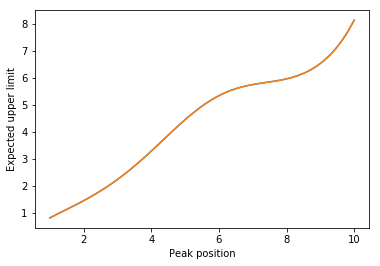

In [5]:
# Instantiate FunkFish object, which builds Swordfish object from function and its variations
FF = sf.FunkFish(flux_func, Sigma, exposure, [0.01, 5., 1.], constraints = [None, 1e-3, None])
FFN = sf.FunkFish(flux_func, None, exposure, [0.01, 5., 1.], constraints = [None, 1e-3, None])

# Generation of upper limits table
pos_list = np.linspace(1, 10, N)
ul = [FF.get_EffectiveCounts({1: p}).upperlimit(0.05, 0) for p in pos_list]
ulN = [FFN.get_EffectiveCounts({1: p}).upperlimit(0.05, 0) for p in pos_list]

# Plot
plt.plot(pos_list, ul)
plt.plot(pos_list, ulN)
plt.xlabel("Peak position")
plt.ylabel("Expected upper limit")

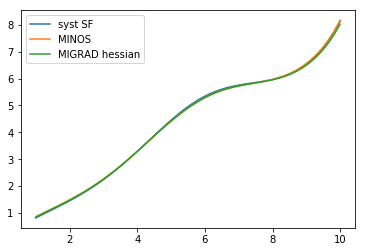

In [6]:
ulM = []
ulMIN = []
for pos in pos_list:
    MI = FF.get_iminuit({0: 1., 1: pos, 2:1.})
    MI.print_level = 0
    MI.migrad()
    MI.minos(var = 'x0', sigma = 1.69)
    ulM.append(MI.errors['x0']*1.69)
    ulMIN.append(MI.merrors[('x0',1.0)])
plt.plot(pos_list, ul, label='syst SF')
#plt.plot(pos_list, ulN, label='no syst SF')
plt.plot(pos_list, ulMIN, label='MINOS')
plt.plot(pos_list, ulM, label='MIGRAD hessian')
plt.legend()

## Reconstruction power

### Map Fisher matrix

In [7]:
norm_list = np.linspace(2, 20, M)
FF = sf.FunkFish(flux_func, Sigma, exposure, [0.00, 2., 1.])
tf = FF.get_TensorFields(1,0, pos_list, norm_list)

### Quiver plot showing major and minor axis of Fisher information metric
Useful for cross-checks. If the figures shows dis-continuities, probably the sample grid needs to be finer.

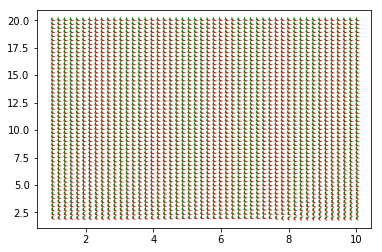

In [8]:
tf.quiver()

### 1, 2, 3-sigma contours from geodesics

(0, 20)

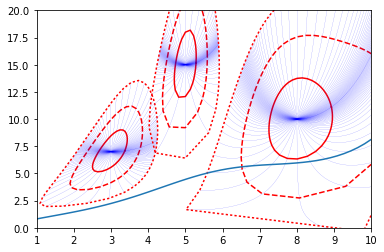

In [9]:
def plot_contours(pos, norm):
    for th, ls, pg in zip([1., 2., 3.], ['-', '--', ':'], [False, False, True]):
        contour = tf.get_contour([pos, norm], th, plot_geodesics = pg, Npoints = 128)
        plt.plot(contour.T[0], contour.T[1], color='r', ls=ls)
                
plot_contours(8., 10.0)
plot_contours(3., 7.0)
plot_contours(5., 15.0)
     
plt.plot(pos_list, ul)
plt.xlim([1, 10])
plt.ylim([0, 20])

(0, 20)

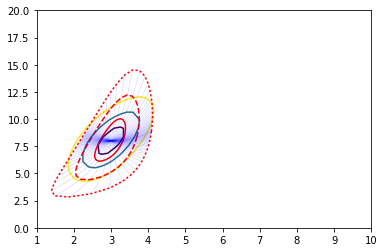

In [10]:
FF = sf.FunkFish(flux_func, Sigma, exposure, [8., 3., 1.], constraints = [None, None, 1e-1])
MI = FF.get_iminuit()
MI.print_level = 0
MI.migrad()
c = MI.contour("x1", "x0", subtract_min = True, bound = 4)
plt.contour(*c, levels = [1., 4., 9.])
plot_contours(3., 8.)
plt.xlim([1,10])
plt.ylim([0, 20])

### Visualization of information metric with streamlines

(0, 20)

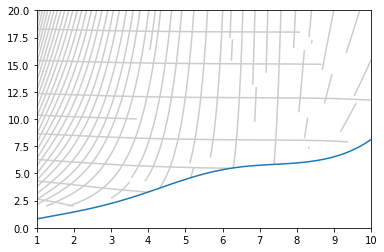

In [11]:
vf1, vf2 = tf.get_VectorFields()
mask = lambda x, y: (y<20) & (y>np.interp(x, pos_list, ul)) & (x>1) & (x<10)
lines = vf1.get_streamlines([5,12.], Nmax = 80, Nsteps = 30, mask = mask)
for line in lines:
    plt.plot(line.T[0], line.T[1], '0.8')
lines = vf2.get_streamlines([5,12.], Nmax = 80, Nsteps = 30, mask = mask)
for line in lines:
    plt.plot(line.T[0], line.T[1], '0.8')

plt.plot(pos_list, ul)
plt.xlim([1, 10])
plt.ylim([0, 20])

### Jeffereys prior as estimate for model reconstruction density

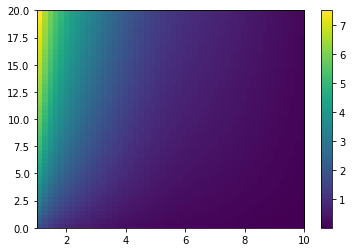

In [13]:
jp = np.array([[np.linalg.det(g)**0.5 for g in row] for row in tf.g])
extent = (1, 10, 0, 20)
plt.imshow(jp[::-1], extent = extent, aspect='auto')
plt.colorbar()